In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras import Model
from tensorflow.keras.initializers import RandomNormal, RandomUniform
from tensorflow.keras.optimizers import Adam

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
mat = scipy.io.loadmat('mnist_all.mat')
L = 28
MS = 8
c = 1 

Kx = 4
Ky = 4
N1 = 784
N2 = Kx*Ky

Nc = 10
Ns = 60000

mu = 0.01
sigma = 0.01
N_steps = 3

beta = 1.
R0 = 3 

batch_size = 500
eps = 0.02
N_ep = 10000

tau = 1.0
dt = 0.2

M=np.zeros((0,N1))
for i in range(Nc):
    M = np.concatenate((M, mat['train'+str(i)]), axis=0)
M = M/255.


In [4]:
class MHN_WITH_1_HIDDEN_LAYER(tf.keras.layers.Layer):
    def __init__(self, N1=N1, N2=N2, c=c, **kwargs):
        super().__init__(**kwargs)
        self.N1 = N1
        self.N2 = N2
        self.c = c
        

    def build(self, input_shape):
        self.kernel = self.add_weight(
            "kernel",
            shape=[self.N1, self.N2],
            initializer=RandomNormal(mean=mu, stddev=sigma, seed=None)
        )
        self.beta = self.add_weight(
            "beta",
            shape=[1, 1],
            initializer=RandomNormal(mean=beta, stddev=0.01, seed=None)
        )
        self.R = self.add_weight(
            "R",
            shape=[1, 1],
            initializer=RandomNormal(mean=R0, stddev=0.01, seed=None)
        )
        self.alpha = self.add_weight(
            "alpha",
            shape=[1, 1],
            initializer=RandomNormal(mean=dt/tau, stddev=0.01, seed=None)
        )
        
        super().build(input_shape)

    def call(self, v, mask):
        nc = tf.sqrt(tf.reduce_sum(tf.square(self.kernel), axis=[0]))
        Mem = self.kernel/nc*self.R
        
        h = tf.matmul(v,Mem)
        SM = tf.nn.softmax(self.beta*h)
        U = tf.matmul(SM, tf.transpose(Mem)) - v
        return [v + self.alpha*U*mask, SM]
                    

In [5]:
tf.keras.backend.clear_session()
input_mask = Input(shape=[L*L*c])
input1 = Input(shape=[L*L*c])
MHN_cell = MHN_WITH_1_HIDDEN_LAYER(N1, N2)

x, SM = MHN_cell(input1, input_mask)
for _ in range(N_steps-1):
    x, SM = MHN_cell(x, input_mask)
        
model = Model(inputs=[input1, input_mask], outputs=x)

2022-05-23 11:07:29.302517: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-23 11:07:33.649342: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38420 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:17:00.0, compute capability: 8.0


In [6]:
tf.keras.utils.plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 mhn_with_1_hidden_layer (MHN_W  [(None, 784),       12547       ['input_2[0][0]',                
 ITH_1_HIDDEN_LAYER)             (None, 16)]                      'input_1[0][0]',                
                                                                  'mhn_with_1_hidden_layer[0][0]',
                                                                  'input_1[0][0]',            

In [8]:
optimizer = Adam(learning_rate=eps)

train_dataset = tf.data.Dataset.from_tensor_slices((M, M))
train_dataset = train_dataset.shuffle(Ns).batch(batch_size)

In [9]:
def print_status_bar(iteration, total, loss, metrics=None):
    metrics = ' - '.join(["{}: {:.4f}".format('loss', m) for m in [loss] + (metrics or [])])
    end = '' if iteration < total else '\n'
    print('\r{}/{} - '.format(iteration, total) + metrics, end=end)

In [10]:
def draw_weights(fig, synapses, Kx, Ky):
    fig.clf()
    yy=0
    HM=np.zeros((L*Ky,L*Kx))
    for y in range(Ky):
        for x in range(Kx):
            HM[y*L:(y+1)*L,x*L:(x+1)*L]=synapses[yy,:].reshape(L,L)
            yy += 1

    nc=np.amax(np.absolute(HM))
    im=plt.imshow(HM,cmap='bwr',vmin=-nc,vmax=nc)
    fig.colorbar(im,ticks=[np.amin(HM), 0, np.amax(HM)])
    plt.axis('off')
    fig.canvas.draw()

In [11]:
def mean_squared_error(y_true, y_pred):
    loss = tf.reduce_mean(tf.square(y_true-y_pred))*L*L/(MS*MS)
    return loss

<IPython.core.display.Javascript object>


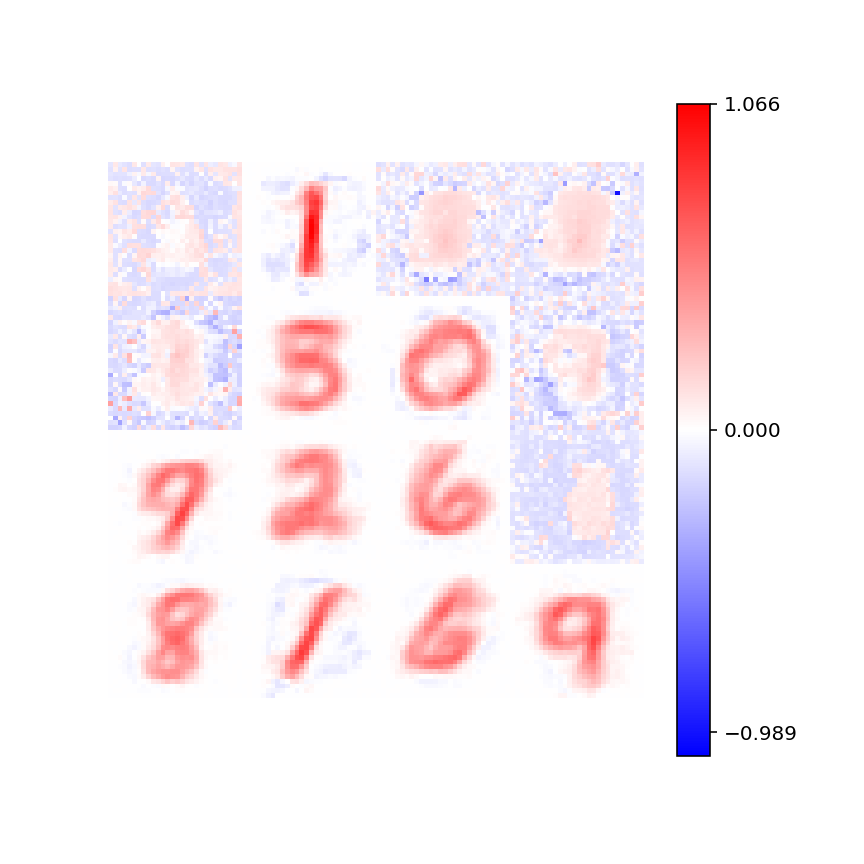

Epoch 1/10000


2022-05-23 11:09:26.876346: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


60000/60000 - loss: 0.3590
Current beta is:  1.286922 , current R is:  3.3492875 , current alpha is:  0.45911923
Epoch 2/10000
60000/60000 - loss: 0.3465
Current beta is:  1.4535551 , current R is:  3.6872146 , current alpha is:  0.6240077
Epoch 3/10000
3000/60000 - loss: 0.3363

KeyboardInterrupt: 

In [12]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(6,6))

for epoch in range(1, N_ep+1):
    print(f'Epoch {epoch}/{N_ep}')

    for step, (x_train, y_train) in enumerate(train_dataset):
        # masking training data
        x_train = tf.cast(tf.reshape(x_train,[-1,L,L,1]),dtype=tf.float32)
        y_train = tf.cast(y_train,dtype=tf.float32)
        x_train_masked = tfa.image.random_cutout(x_train, (MS, MS), constant_values=-1.)
        mask = 1. - tf.cast(tf.equal(x_train, x_train_masked), dtype=tf.float32)
        x_train_masked = x_train*tf.cast(1.0-mask, dtype=tf.float32)
        x_train_masked = tf.reshape(x_train_masked, [-1,L*L*c])
        mask = tf.cast(tf.reshape(mask, [-1,L*L*c]), dtype=tf.float32)
        
        # update weights
        with tf.GradientTape() as tape:
            y_pred = model([x_train_masked, mask])
            loss = mean_squared_error(y_train, y_pred)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.learning_rate.assign(eps)
        optimizer.apply_gradients(zip(gradients[:1], model.trainable_variables[:1]))
        
        optimizer.learning_rate.assign(eps/10)
        optimizer.apply_gradients(zip(gradients[1:], model.trainable_variables[1:]))

        for _ in range(1,len(model.trainable_variables)):
            model.trainable_variables[_].assign(tf.clip_by_value(model.trainable_variables[_], 0.01, 100))
        
        
        #print_status_bar
        print_status_bar((step+1)*batch_size, Ns, tf.sqrt(loss))

        # plot weights
        KS = model.layers[2].get_weights()[0]
        current_beta = model.layers[2].get_weights()[1][0][0]
        current_R = model.layers[2].get_weights()[2][0][0]
        current_alpha = model.layers[2].get_weights()[3][0][0]
    print('Current beta is: ', current_beta, ', current R is: ', current_R, ', current alpha is: ', current_alpha)
    draw_weights(fig, KS.T, Kx, Ky)


In [13]:
def draw_data(fig, dat, Kx, Ky):
    fig.clf()
    yy = 0
    HM = np.zeros((L*Ky,L*Kx))
    for y in range(Ky):
        for x in range(Kx):
            HM[y*L:(y+1)*L,x*L:(x+1)*L] = dat[yy,:].reshape(L,L)
            yy += 1

    nc = np.amax(np.absolute(HM))
    im = plt.imshow(HM,cmap='bwr',vmin=-nc,vmax=nc)
    fig.colorbar(im,ticks=[np.amin(HM), 0, np.amax(HM)])
    plt.axis('off')        
    fig.canvas.draw()

<IPython.core.display.Javascript object>


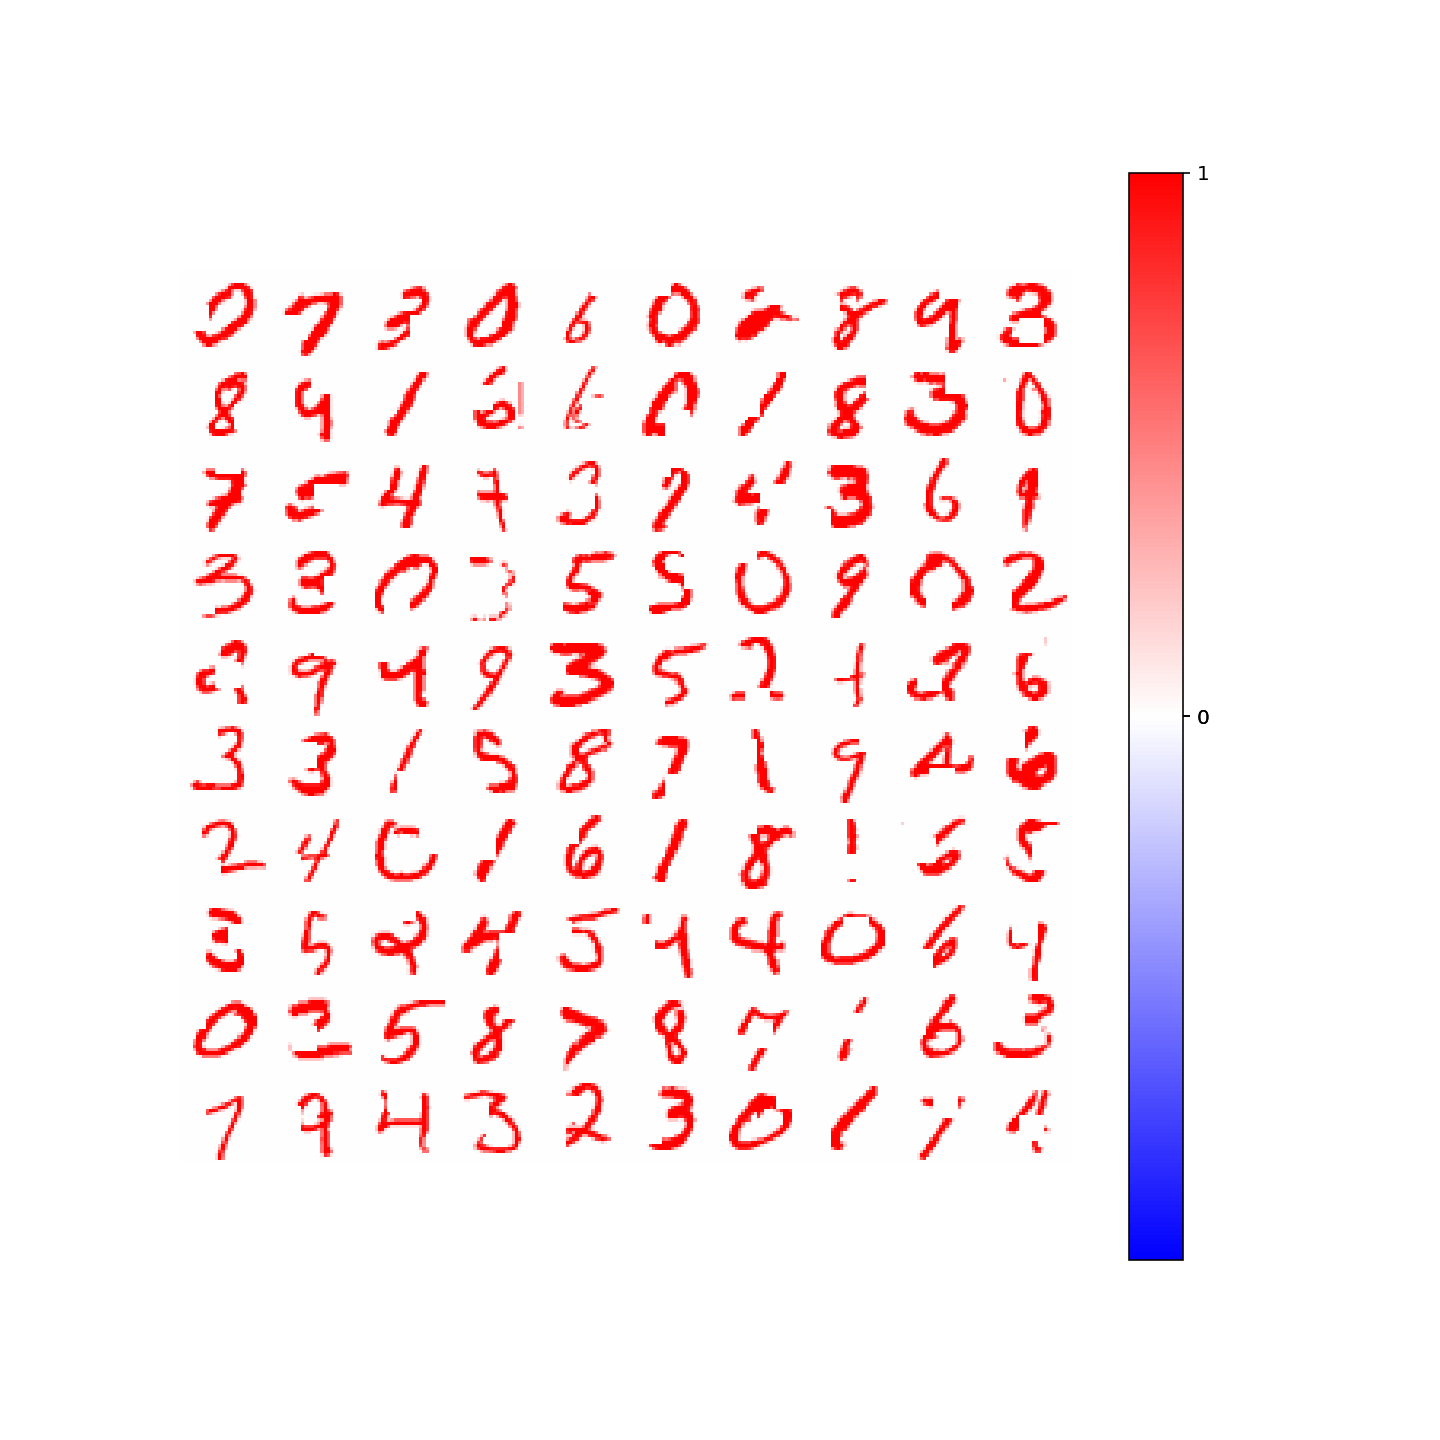

<IPython.core.display.Javascript object>


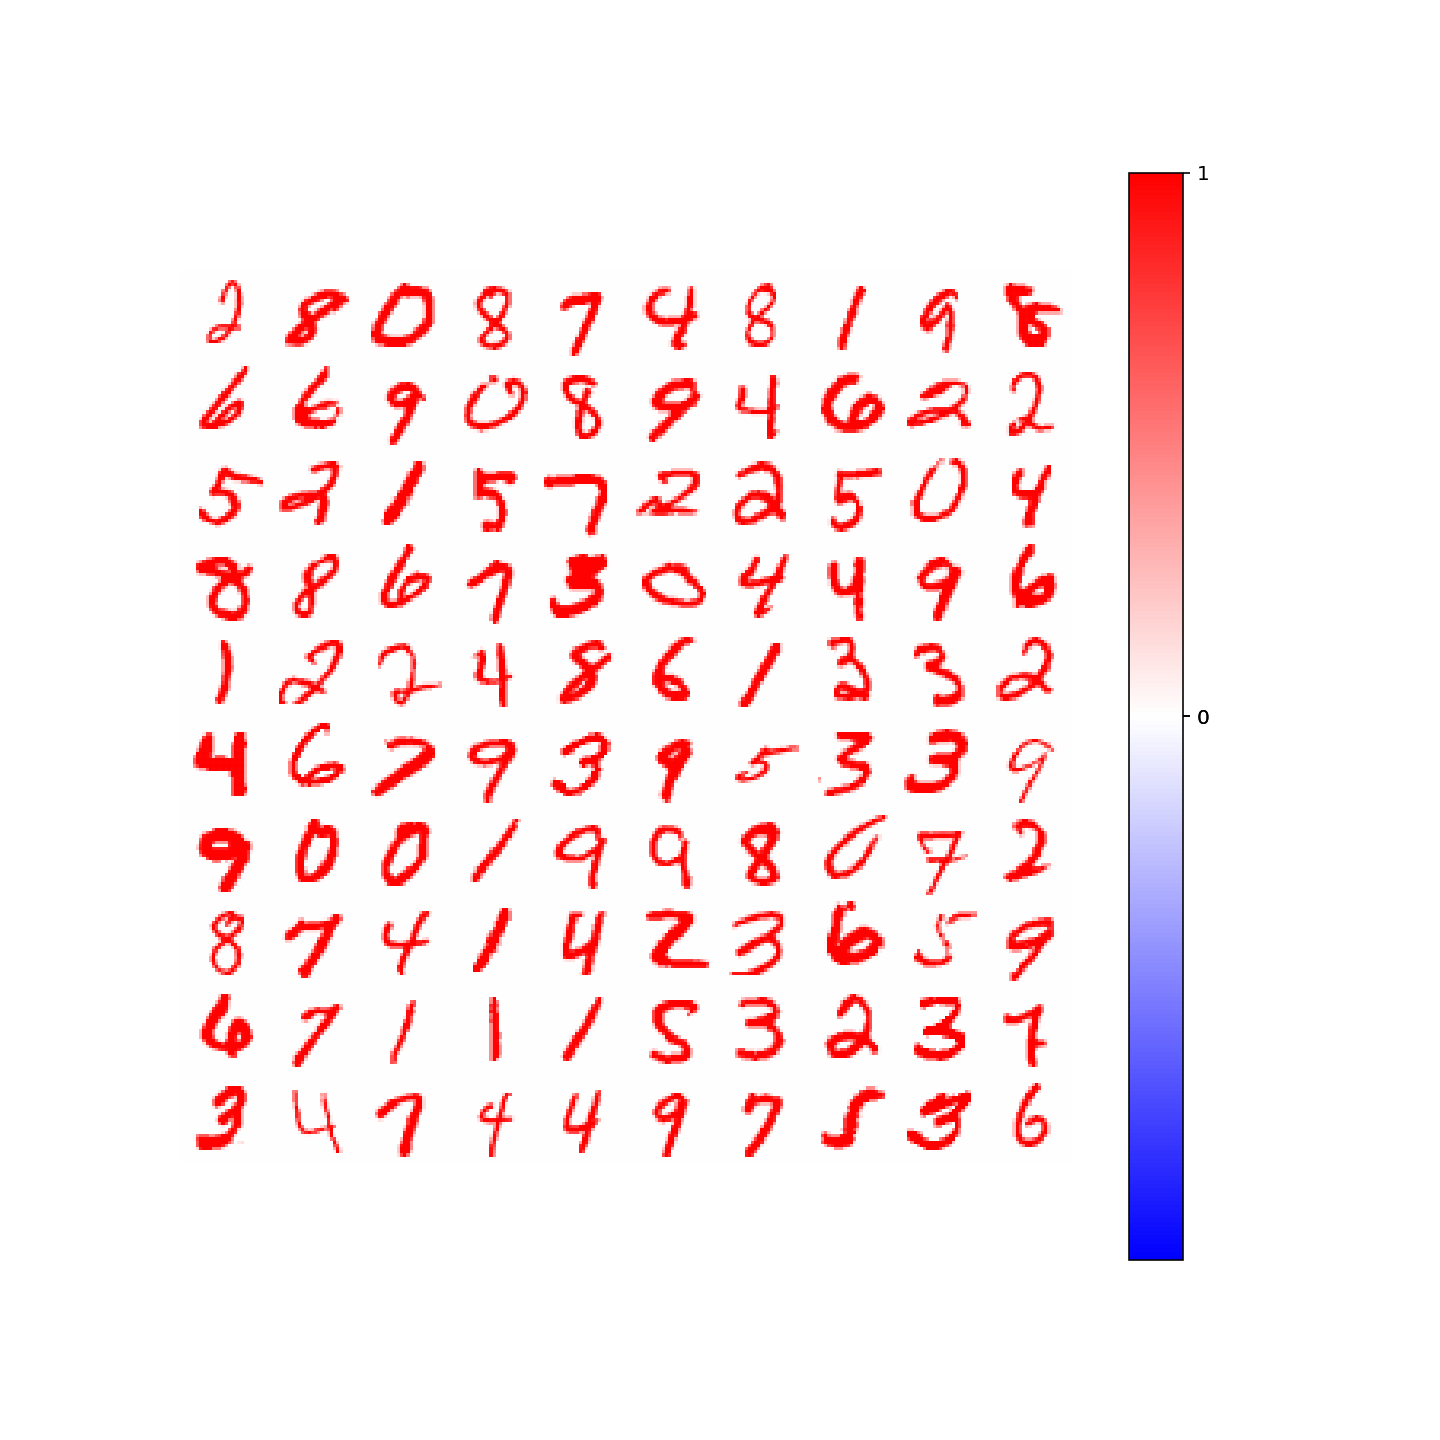

<IPython.core.display.Javascript object>


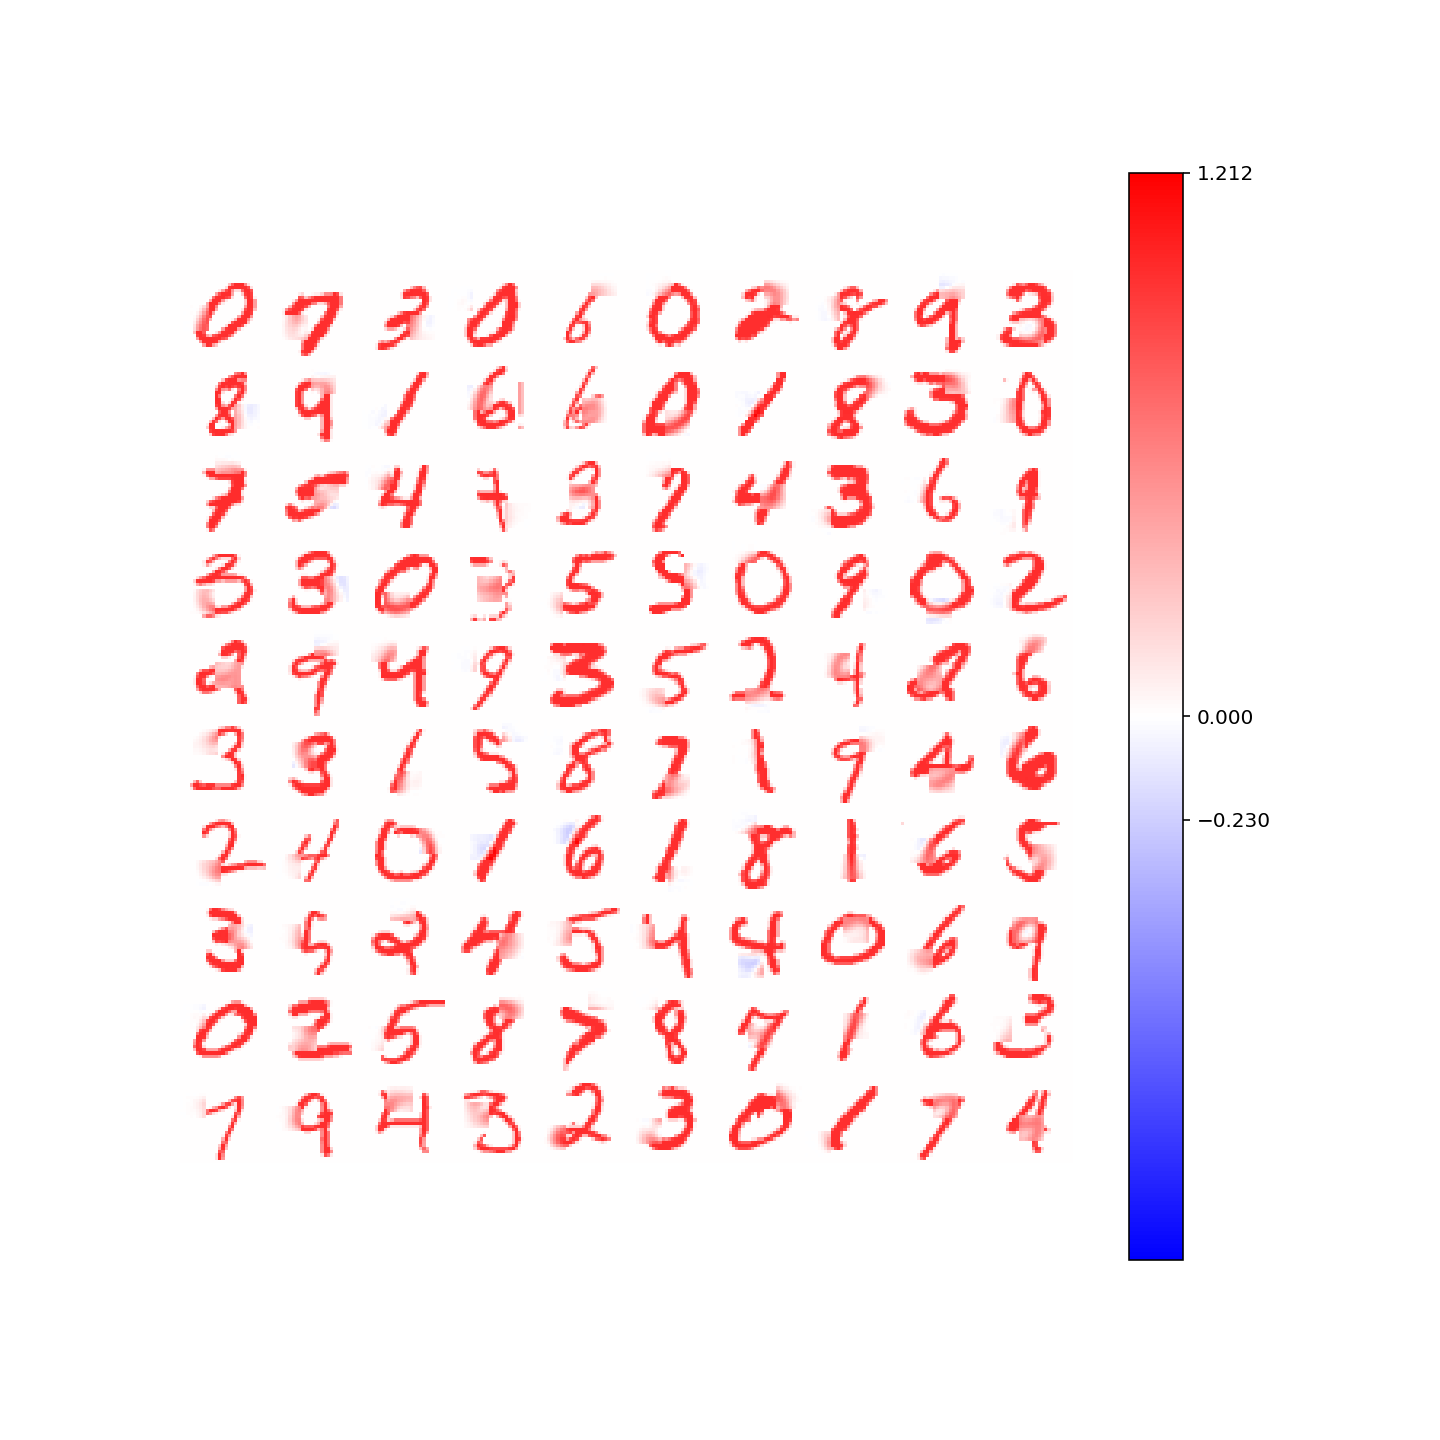

In [14]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(10,10))
draw_data(fig, x_train_masked.numpy(), 10,10)

fig1=plt.figure(figsize=(10,10))
draw_data(fig1, y_train.numpy(), 10,10)

fig2=plt.figure(figsize=(10,10))
draw_data(fig2, y_pred.numpy(), 10,10)
